# Recommendation Systems

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2,EfficientNetB2, VGG16
from tensorflow.keras.layers import GlobalMaxPool2D, Dense
import tensorflow_hub as hub

from sklearn.neighbors import NearestNeighbors
import os
from numpy.linalg import norm
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices("GPU")

[]

In [3]:
data = pd.read_csv("train_data.csv")

In [4]:
filenames = []
for file in os.listdir('train/train/'):
    filenames.append(os.path.join('train/train/',file))    

In [5]:
filenames_test = []
for file in os.listdir('test/test/'):
    filenames_test.append(os.path.join('test/test/',file))    

In [6]:
cities=data.city.to_numpy()
unique_cities=np.unique(cities)
boolean_cities=[label==unique_cities for label in cities]

In [7]:
len(filenames)

7000

In [8]:
#X_train, X_test, y_train, y_test = train_test_split(filenames, boolean_cities, test_size=0.2, random_state=42)

In [9]:
#Importing  Model and Cofiguration

In [10]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.trainable = False

model = tf.keras.models.Sequential([model,
                                   GlobalMaxPool2D()
                                   ])
model.summary()

#0.67 acc

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [11]:
#Extracting Fetaures from Image

In [12]:
def extract_features_from_images(image_path, model):
    img = image.load_img(image_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_expand_dim)
    result = model.predict(img_expand_dim).flatten()
    norm_result = result/norm(result)
    return norm_result

In [13]:
extract_features_from_images(filenames[0], model)

1/1 [==============================] - 1s 1s/step


array([0.00272799, 0.01719832, 0.01904317, ..., 0.03568538, 0.00322245,
       0.01403188], dtype=float32)

In [14]:
X_train_features = []
for file in filenames:
    X_train_features.append(extract_features_from_images(file, model))

1/1 [==============================] - 0s 408ms/step


In [15]:
X_test_features = []
for file in filenames_test:
    X_test_features.append(extract_features_from_images(file, model))

1/1 [==============================] - 1s 613ms/step


In [16]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Modeli
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_features, boolean_cities)

KNeighborsClassifier()

In [17]:
# Test Performansı
#accuracy = knn.score(X_test_features, y_test)
#accuracy

In [ ]:
#Writing pkl

In [18]:
Image_features = pkl.dump(X_train_features, open('Images_features.pkl','wb'))

In [19]:
filenames = pkl.dump(filenames, open('filenames.pkl','wb'))

In [43]:
Image_features_test = pkl.dump(X_test_features, open('Images_features_test.pkl','wb'))

In [44]:
filenames_test = pkl.dump(filenames_test, open('filenames_test.pkl','wb'))

In [20]:
#Loading Pickle Files

In [21]:
Image_features = pkl.load(open('Images_features.pkl','rb'))

In [22]:
filenames = pkl.load(open('filenames.pkl','rb'))

In [70]:
Image_features_test = pkl.load(open('Images_features_test.pkl','rb'))

In [71]:
filenames_test = pkl.load(open('filenames_test.pkl','rb'))

In [23]:
np.array(Image_features).shape

(7000, 2048)

In [ ]:
#knn

In [322]:
input_image = extract_features_from_images('test/test/image_18846.jpg',model)

1/1 [==============================] - 1s 1s/step


In [323]:
distance,indices = knn.kneighbors([input_image])

In [324]:
distance

array([[0.65338331, 0.65402236, 0.65901532, 0.65937517, 0.66634781]])

In [262]:
indices[0]

array([4005, 5973, 4768,   31, 5403], dtype=int64)

In [263]:
city_values = data.loc[indices[0], 'city']
city_values

4005       Izmir
5973      Ankara
4768      Ankara
31      Istanbul
5403      Ankara
Name: city, dtype: object

In [252]:
from IPython.display import Image

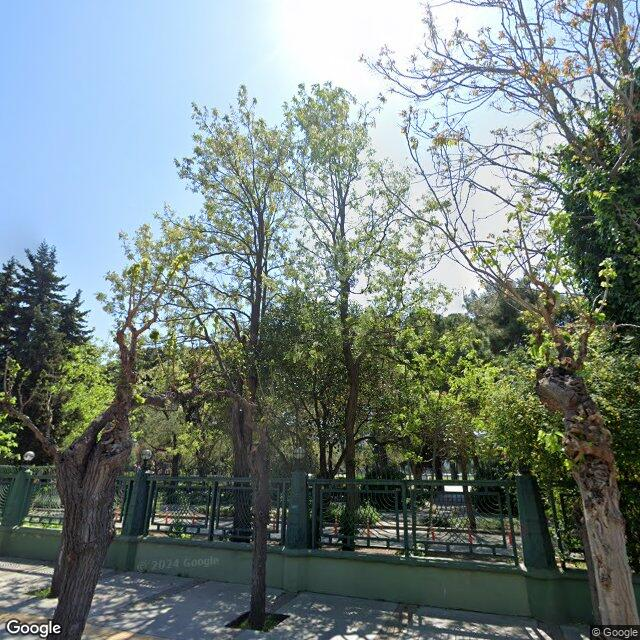

In [264]:
Image('test/test/image_18796.jpg')

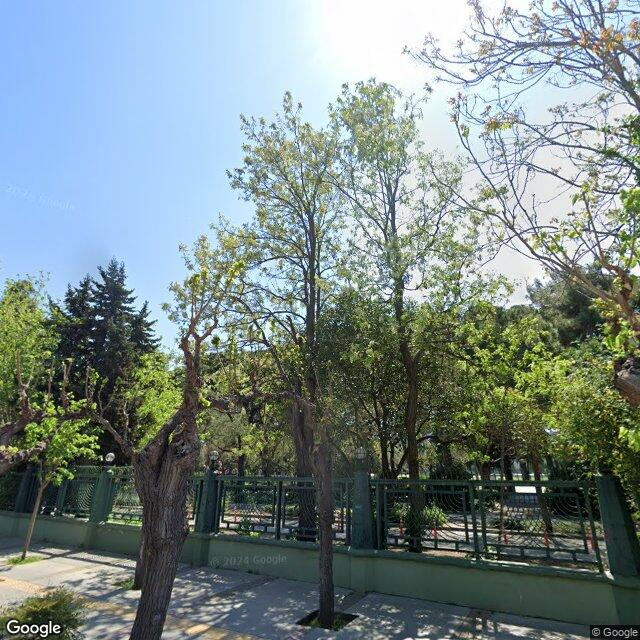

In [265]:
Image(filenames[indices[0][0]])

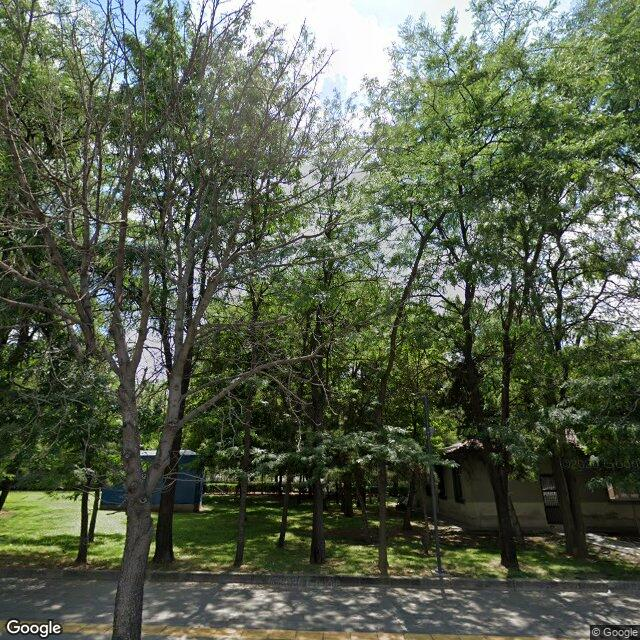

In [266]:
Image(filenames[indices[0][1]])

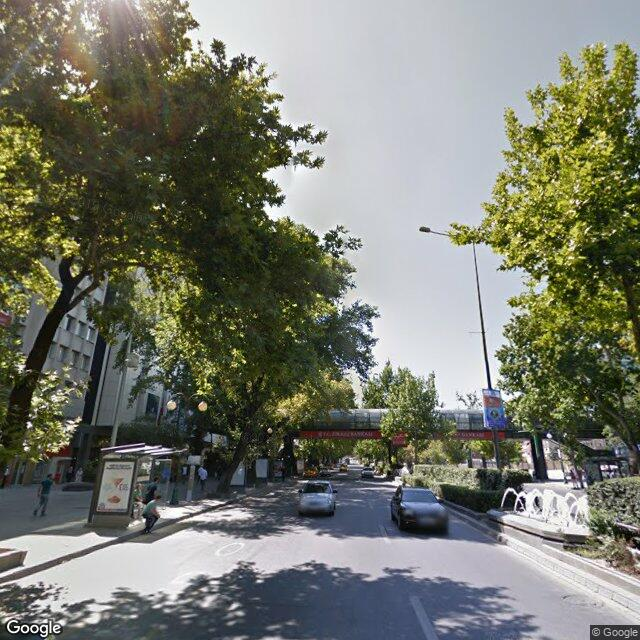

In [267]:
Image(filenames[indices[0][2]])

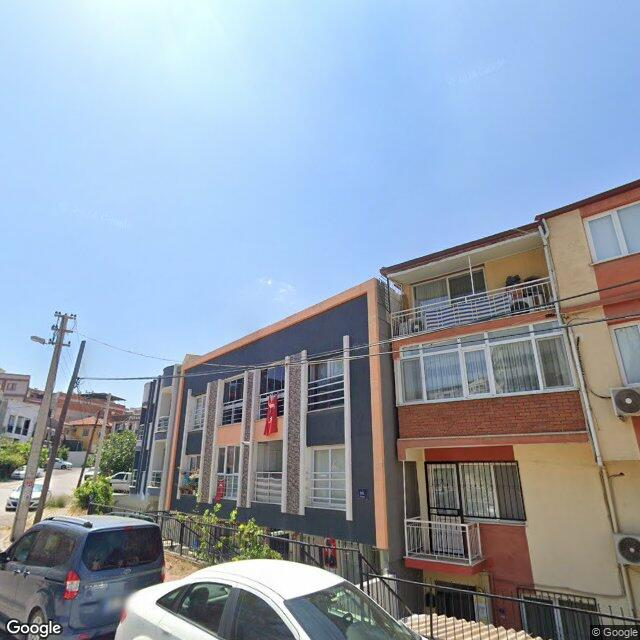

In [257]:
Image(filenames[indices[0][3]])

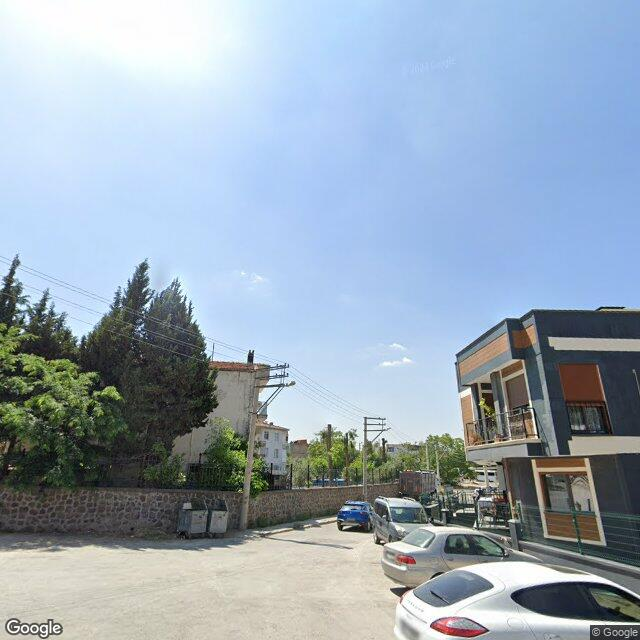

In [258]:
Image(filenames[indices[0][4]])

In [89]:
y_test = []  

for input_image in Image_features_test:
    distance, indices = knn.kneighbors([input_image])
    city_values = data.loc[indices[0], 'city']
    result = city_values.iloc[0]     
    y_test.append(result)

In [83]:
"""y_test = []  

for filename in filenames_test:
    input_image = extract_features_from_images(filename, model)
    distance, indices = knn.kneighbors([input_image])
    city_values = data.loc[indices[0], 'city']
    subset = city_values[:3]
    
    if subset.nunique() == len(subset):
        result = subset.iloc[0]  
    else:
        result = subset.mode().iloc[0]  
    
    y_test.append(result)"""

1/1 [==============================] - 1s 994ms/step


In [90]:
df_test=pd.read_csv("test.csv")

In [91]:
df_test["city"]= y_test

In [92]:
df_test.head()

,filename,city
0,image_17000.jpg,Izmir
1,image_17001.jpg,Izmir
2,image_17002.jpg,Istanbul
3,image_17003.jpg,Istanbul
4,image_17004.jpg,Izmir


In [93]:
df_test[25:26] #izmir

,filename,city
25,image_17025.jpg,Izmir


In [94]:
df_test.to_csv("submission6_knn.csv", index=False)

In [95]:
import pandas as pd

# Dosyaları yükle
file1 = pd.read_csv('submission2.csv')  # Birinci dosyanın adı
file2 = pd.read_csv('submission6_knn.csv')  # İkinci dosyanın adı

# İki sütunu karşılaştır
same_count = (file1['city'] == file2['city']).sum()  # Aynı olanların sayısı
different_count = len(file1) - same_count  # Farklı olanların sayısı

# Sonuçları yazdır
print(f"Aynı değerlerin sayısı: {same_count}")
print(f"Farklı değerlerin sayısı: {different_count}")


Aynı değerlerin sayısı: 1548
Farklı değerlerin sayısı: 452


In [96]:
# Farklı olanları filtrele
different_rows = file1['city'] != file2['city']  # Farklı olan satırları tespit et

# Farklı olan satırların filename sütunlarını al
different_filenames = file1.loc[different_rows, 'filename']

# Sonuçları yazdır
print("Farklı değerlerdeki filename sütunları:")
print(different_filenames.tolist())  # Liste olarak görüntülemek için

Farklı değerlerdeki filename sütunları:
['image_17006.jpg', 'image_17011.jpg', 'image_17013.jpg', 'image_17016.jpg', 'image_17021.jpg', 'image_17022.jpg', 'image_17024.jpg', 'image_17029.jpg', 'image_17055.jpg', 'image_17056.jpg', 'image_17059.jpg', 'image_17060.jpg', 'image_17064.jpg', 'image_17066.jpg', 'image_17072.jpg', 'image_17077.jpg', 'image_17080.jpg', 'image_17083.jpg', 'image_17085.jpg', 'image_17086.jpg', 'image_17088.jpg', 'image_17089.jpg', 'image_17096.jpg', 'image_17098.jpg', 'image_17103.jpg', 'image_17108.jpg', 'image_17120.jpg', 'image_17121.jpg', 'image_17122.jpg', 'image_17126.jpg', 'image_17130.jpg', 'image_17131.jpg', 'image_17134.jpg', 'image_17135.jpg', 'image_17150.jpg', 'image_17159.jpg', 'image_17167.jpg', 'image_17169.jpg', 'image_17176.jpg', 'image_17188.jpg', 'image_17189.jpg', 'image_17193.jpg', 'image_17203.jpg', 'image_17205.jpg', 'image_17207.jpg', 'image_17209.jpg', 'image_17213.jpg', 'image_17216.jpg', 'image_17224.jpg', 'image_17225.jpg', 'image_17

In [334]:
low_distance_filenames= [] 
group_count_below_50 = 0

for filename in filenames_test:
    input_image = extract_features_from_images(filename, model)
    distance, indices = knn.kneighbors([input_image])  # distance ve indices'i al
    
    if np.any(distance[0] < 0.50):  # group[0] içinde 0.50'dan küçük bir değer varsa
        group_count_below_50 += 1
        low_distance_filenames.append(filename)

1/1 [==============================] - 1s 1s/step


KeyboardInterrupt: 

In [347]:
len(low_distance_filenames)

526

In [346]:
low_distance_filenames_split = [filename.split('test/test/')[-1] for filename in low_distance_filenames]

In [357]:
# Dosyaları oku
sub2 = file1
sub6 = file2[file2['filename'].isin(low_distance_filenames_split)]

In [358]:
sub6.head()

,filename,city
2,image_17002.jpg,Istanbul
8,image_17008.jpg,Izmir
9,image_17009.jpg,Izmir
14,image_17014.jpg,Ankara
19,image_17019.jpg,Ankara


In [359]:
sub6.shape

(526, 2)

In [360]:
sub2.shape

(2000, 2)

In [361]:
# Aynı 'filename' değerine sahip satırlarda sub6'daki city değerini sub2'ye ata
sub2.loc[sub2['filename'].isin(sub6['filename']), 'city'] = sub2['filename'].map(sub6.set_index('filename')['city'])


In [362]:
sub2.shape

(2000, 2)

In [363]:
sub2.to_csv('updated_sub2.csv', index=False)